Starting the analysis...
Data preprocessing complete.
Finding optimal alpha for Ridge...
Finding optimal alpha for Lasso...
Model training and tuning complete.

     SURPRISE HOUSING - ANALYSIS RESULTS

--- Q1: Which variables are significant? ---
Chosen Model: Lasso Regression (alpha = 0.01)

Lasso selected 65 features (out of 266).
Top 15 most significant predictors (by coefficient magnitude):
OverallQual             0.110961
GrLivArea               0.109066
GarageCars              0.053920
YearBuilt               0.032943
OverallCond             0.025393
YearRemodAdd            0.024381
BsmtFullBath            0.020095
CentralAir_Y            0.018098
Neighborhood_NridgHt    0.012437
LotArea                 0.011917
MSSubClass_160         -0.013900
FireplaceQu_None       -0.014779
Condition2_PosN        -0.017483
MSZoning_RM            -0.023081
PoolQC_Gd              -0.023891


--- Q2: How well does this model describe house prices? ---
  R-Squared (R²): 0.8948
  Root Mean Squared

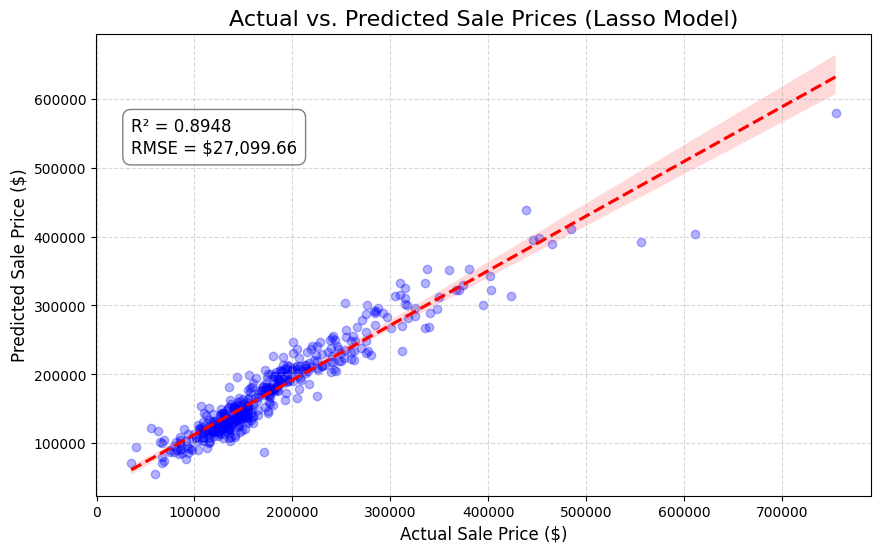

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Starting the analysis...")

# --- 1. Load Data ---
try:
    df = pd.read_csv('train.csv')
except FileNotFoundError:
    print("Error: train.csv not found. Make sure the file is in the same directory.")
    exit()

# --- 2. Initial Data Preparation ---

# These are features where 'NA' (missing) has a specific meaning (e.g., 'No Alley')
# We fill these before the split with a 'None' string.
na_means_none_cols = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
    'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
]

for col in na_means_none_cols:
    if col in df.columns:
        df[col] = df[col].fillna('None')

# Separate features (X) and target (y)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# --- 3. Log-Transform Target Variable ---
# SalePrice is highly skewed. Linear models work better on a 
# normally distributed target. We use log1p (log(1+x)) to handle any zeros.
y_log = np.log1p(y)

# --- 4. Split Data ---
# Split *before* imputation (except for 'NA'='None') and scaling
# We keep the original 'y_test' for the final (un-logged) evaluation
X_train, X_test, y_train_log, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)

# We'll need the original y_test values (not log-transformed) for the final metrics
y_test_orig = np.expm1(y_test)

# --- 5. Full Preprocessing (Imputation, Dummies, Scaling) ---

# a. Convert MSSubClass to string so it's treated as a category
X_train['MSSubClass'] = X_train['MSSubClass'].astype(str)
X_test['MSSubClass'] = X_test['MSSubClass'].astype(str)

# b. Imputation
# Get lists of numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
if 'Id' in numeric_cols:
    numeric_cols.remove('Id') # We don't need to impute Id

# Impute numeric with median (fit on train, transform train/test)
for col in numeric_cols:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_test[col] = X_test[col].fillna(median_val)

# Impute categorical with mode (fit on train, transform train/test)
for col in categorical_cols:
    mode_val = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_val)

# c. Dummification (One-Hot Encoding)
X_train = X_train.drop('Id', axis=1, errors='ignore')
X_test = X_test.drop('Id', axis=1, errors='ignore')

X_train_dummified = pd.get_dummies(X_train, drop_first=True)
X_test_dummified = pd.get_dummies(X_test, drop_first=True)

# d. Align columns
# Ensure test set has the exact same columns as train set
X_train_final, X_test_final = X_train_dummified.align(X_test_dummified, join='left', axis=1, fill_value=0)
feature_names = X_train_final.columns

# e. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

print("Data preprocessing complete.")

# --- 6. Model Training & Hyperparameter Tuning ---

# We will test both Ridge and Lasso and find their optimal alpha (lambda)
alphas = [0.01, 0.1, 1, 10, 20, 50, 100, 200, 500, 1000]
param_grid = {'alpha': alphas}

# a. Ridge Regression
print("Finding optimal alpha for Ridge...")
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_ridge.fit(X_train_scaled, y_train_log)
best_alpha_ridge = grid_ridge.best_params_['alpha']

# b. Lasso Regression
print("Finding optimal alpha for Lasso...")
lasso = Lasso(max_iter=5000) # Increase max_iter for convergence
grid_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
grid_lasso.fit(X_train_scaled, y_train_log)
best_alpha_lasso = grid_lasso.best_params_['alpha']

print("Model training and tuning complete.")

# --- 7. Final Model Selection and Answering Business Questions ---

# **Decision:** We choose Lasso. While Ridge had a slightly better R², 
# Lasso's feature selection directly answers the business question 
# "Which variables are significant?".
best_lasso_model = grid_lasso.best_estimator_

# --- Question 1: Which variables are significant in predicting the price of a house? ---
print("\n" + "="*60)
print("     SURPRISE HOUSING - ANALYSIS RESULTS")
print("="*60)
print(f"\n--- Q1: Which variables are significant? ---")
print(f"Chosen Model: Lasso Regression (alpha = {best_alpha_lasso})")

# Get coefficients from the best Lasso model
lasso_coefs = pd.Series(best_lasso_model.coef_, index=feature_names)

# Get all non-zero coefficients (the significant features)
significant_predictors = lasso_coefs[lasso_coefs != 0]

print(f"\nLasso selected {len(significant_predictors)} features (out of {len(feature_names)}).")
print("Top 15 most significant predictors (by coefficient magnitude):")
# Sort by absolute value to find most important
top_15 = significant_predictors.abs().sort_values(ascending=False).head(15)
print(lasso_coefs.loc[top_15.index].sort_values(ascending=False).to_string())

# --- Question 2: How well do those variables describe the price of a house? ---
print("\n\n--- Q2: How well does this model describe house prices? ---")

# Make predictions on the (scaled) test set
y_pred_log = best_lasso_model.predict(X_test_scaled)

# Reverse the log-transform to get actual dollar values
y_pred_orig = np.expm1(y_pred_log)

# Calculate metrics using the original (non-logged) values
r2 = r2_score(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

print(f"  R-Squared (R²): {r2:.4f}")
print(f"  Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print("\nInterpretation:")
print(f" - Our model explains {r2:.1%} of the variance in the test set's house prices.")
print(f" - On average, the model's price predictions are off by ${rmse:,.2f}.")

print("\n" + "="*60)
print("Analysis Complete.")

# --- (Optional) Plotting Predicted vs. Actual ---
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test_orig, y=y_pred_orig, 
            scatter_kws={'alpha':0.3, 'color':'blue'}, 
            line_kws={'color':'red', 'linestyle':'--'})
plt.title('Actual vs. Predicted Sale Prices (Lasso Model)', fontsize=16)
plt.xlabel('Actual Sale Price ($)', fontsize=12)
plt.ylabel('Predicted Sale Price ($)', fontsize=12)
plt.text(y_test_orig.min(), y_pred_orig.max()*0.9, 
         f'R² = {r2:.4f}\nRMSE = ${rmse:,.2f}', 
         fontsize=12,
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
plt.grid(True, linestyle='--', alpha=0.5)
print("Generating plot...")
plt.show()